In [38]:
import numpy as np
import pandas as pd 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchsummary import summary
from PIL import Image
from tqdm import tqdm    # for progress bar
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # randomly rotate image +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # randomly flip left-right 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop to 224x224 at center
    transforms.ToTensor(),              # convert image to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225]) # ImageNet std
])

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
device

device(type='cpu')

In [40]:
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [44]:
root = "C:/Users/SEC/Desktop/DLWS2/Cat-Dog_Panda"
train_data = ImageFolder('C:/Users/SEC/Desktop/DLWS2/Cat-Dog_Panda/Train',
                        transform = train_transform)
val_data = ImageFolder('C:/Users/SEC/Desktop/DLWS2/Cat-Dog_Panda/Valid',
                      transform = test_transform)

In [46]:
class_names = train_data.classes   # different classes in our datasets
class_names

['cat', 'dog', 'panda']

In [47]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
dataiter = iter(train_loader)
features,label = next(dataiter)
print('number of data per batch: ',len(features))
print('number of label per batch: ',len(label))
print('labels : ',label.unique())

number of data per batch:  32
number of label per batch:  32
labels :  tensor([0, 1, 2])


In [49]:
class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog', 'panda']
Training images available: 2100
Testing images available:  600


In [50]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
# Unfreeze only deeper layers for fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_features = model.fc.in_features  
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.7),
    nn.Linear(512,128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(128, 3)) # 3 classes dog, cat, pandas
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\SEC/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [04:04<00:00, 420kB/s] 


In [51]:
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [52]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-4)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-6, weight_decay=5e-4)

In [53]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [54]:
num_epochs = 20
early_stopping = EarlyStopping(patience=5, min_delta=0.001)
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0
start_time  = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    # Wrap train_loader with tqdm
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update tqdm bar postfix with running metrics
        train_loader_tqdm.set_postfix({'loss': f"{loss.item():.4f}"})

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            val_loader_tqdm.set_postfix({'loss': f"{loss.item():.4f}"})

    val_loss /= total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    
    # Final log for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'model.pth')
        print(f"💾 Saved best model with val_acc: {val_acc:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"⏹ Early stopping triggered at epoch {epoch+1}")
        break

end_time = time.time()
print(f"\nTraining completed in {(end_time - start_time)/60:.1f} minutes")

Epoch [1/20] Validation: 100%|██████████| 10/10 [00:25<00:00,  2.60s/it, loss=0.9186]


Epoch [1/20] Train Loss: 1.0665, Train Acc: 0.4943 Val Loss: 1.0037, Val Acc: 0.8900
💾 Saved best model with val_acc: 0.8900


Epoch [2/20] Validation: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it, loss=0.7709]


Epoch [2/20] Train Loss: 0.9848, Train Acc: 0.7181 Val Loss: 0.8689, Val Acc: 0.9667
💾 Saved best model with val_acc: 0.9667


Epoch [3/20] Validation: 100%|██████████| 10/10 [00:31<00:00,  3.16s/it, loss=0.5708]


Epoch [3/20] Train Loss: 0.8457, Train Acc: 0.8862 Val Loss: 0.6908, Val Acc: 0.9833
💾 Saved best model with val_acc: 0.9833


Epoch [4/20] Validation: 100%|██████████| 10/10 [00:26<00:00,  2.67s/it, loss=0.4455]


Epoch [4/20] Train Loss: 0.7012, Train Acc: 0.9357 Val Loss: 0.5231, Val Acc: 0.9833


Epoch [5/20] Validation: 100%|██████████| 10/10 [00:30<00:00,  3.02s/it, loss=0.3641]


Epoch [5/20] Train Loss: 0.5639, Train Acc: 0.9600 Val Loss: 0.4161, Val Acc: 0.9833


Epoch [6/20] Validation: 100%|██████████| 10/10 [00:30<00:00,  3.03s/it, loss=0.3142]


Epoch [6/20] Train Loss: 0.4787, Train Acc: 0.9648 Val Loss: 0.3658, Val Acc: 0.9867
💾 Saved best model with val_acc: 0.9867


Epoch [7/20] Validation: 100%|██████████| 10/10 [00:31<00:00,  3.16s/it, loss=0.2974]


Epoch [7/20] Train Loss: 0.4212, Train Acc: 0.9752 Val Loss: 0.3393, Val Acc: 0.9867


Epoch [8/20] Validation: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it, loss=0.2950]


Epoch [8/20] Train Loss: 0.3818, Train Acc: 0.9852 Val Loss: 0.3307, Val Acc: 0.9867


Epoch [9/20] Validation: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it, loss=0.2988]


Epoch [9/20] Train Loss: 0.3688, Train Acc: 0.9857 Val Loss: 0.3255, Val Acc: 0.9900
💾 Saved best model with val_acc: 0.9900


Epoch [10/20] Validation: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it, loss=0.2980]


Epoch [10/20] Train Loss: 0.3638, Train Acc: 0.9824 Val Loss: 0.3264, Val Acc: 0.9867


Epoch [11/20] Validation: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it, loss=0.3005]


Epoch [11/20] Train Loss: 0.3485, Train Acc: 0.9890 Val Loss: 0.3245, Val Acc: 0.9900


Epoch [12/20] Validation: 100%|██████████| 10/10 [00:19<00:00,  1.98s/it, loss=0.2985]


Epoch [12/20] Train Loss: 0.3576, Train Acc: 0.9833 Val Loss: 0.3279, Val Acc: 0.9867


Epoch [13/20] Validation: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it, loss=0.3036]


Epoch [13/20] Train Loss: 0.3507, Train Acc: 0.9838 Val Loss: 0.3260, Val Acc: 0.9900


Epoch [14/20] Validation: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it, loss=0.3108]


Epoch [14/20] Train Loss: 0.3468, Train Acc: 0.9895 Val Loss: 0.3242, Val Acc: 0.9900


Epoch [15/20] Validation: 100%|██████████| 10/10 [00:19<00:00,  1.97s/it, loss=0.3132]


Epoch [15/20] Train Loss: 0.3493, Train Acc: 0.9871 Val Loss: 0.3251, Val Acc: 0.9867


Epoch [16/20] Validation: 100%|██████████| 10/10 [00:23<00:00,  2.39s/it, loss=0.3055]

Epoch [16/20] Train Loss: 0.3385, Train Acc: 0.9924 Val Loss: 0.3240, Val Acc: 0.9900
⏹ Early stopping triggered at epoch 16

Training completed in 119.8 minutes


In [56]:
test_data = ImageFolder('C:/Users/SEC/Desktop/DLWS2/Cat-Dog_Panda/Test',
                       transform=test_transform)
test_loader =DataLoader(test_data, batch_size=32, shuffle=False)

In [57]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f"\n✅ Overall Test Accuracy: {test_accuracy*100:.2f}%")


✅ Overall Test Accuracy: 99.33%


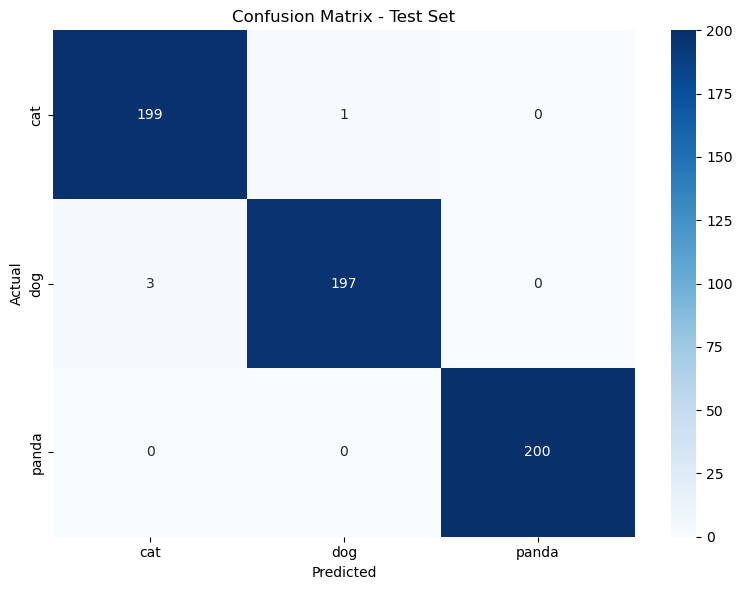

In [58]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [59]:
report = classification_report(all_labels, all_preds, target_names=class_names, 
                               output_dict=True, zero_division=0)

# Prepare metrics dictionary
metrics = {
    'test_accuracy': float(test_accuracy),
    'class': class_names,
    'precision': [float(report[c]['precision']) for c in class_names],
    'recall': [float(report[c]['recall']) for c in class_names],
    'f1-score': [float(report[c]['f1-score']) for c in class_names],
    'support': [int(report[c]['support']) for c in class_names],
    'Macro_Avg': {
        'precision': float(report['macro avg']['precision']),
        'recall': float(report['macro avg']['recall']),
        'f1-score': float(report['macro avg']['f1-score'])
    },
    'Weighted_Avg': {
        'precision': float(report['weighted avg']['precision']),
        'recall': float(report['weighted avg']['recall']),
        'f1-score': float(report['weighted avg']['f1-score'])
    },
    'confusion_matrix': cm.tolist(),
    'history': {
        'train_loss': [float(x) for x in train_losses],
        'val_loss': [float(x) for x in val_losses],
        'train_acc': [float(x) for x in train_accs],
        'val_acc': [float(x) for x in val_accs]
    }
}

# Save metrics
with open('metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("\n📊 Metrics saved to 'metrics.json'")
print("\nPer-class Performance:")
for i, cls in enumerate(class_names):
    print(f"{cls}: Precision={metrics['precision'][i]:.4f}, "
          f"Recall={metrics['recall'][i]:.4f}, F1={metrics['f1-score'][i]:.4f}")


📊 Metrics saved to 'metrics.json'

Per-class Performance:
cat: Precision=0.9851, Recall=0.9950, F1=0.9900
dog: Precision=0.9949, Recall=0.9850, F1=0.9899
panda: Precision=1.0000, Recall=1.0000, F1=1.0000


In [62]:
import torch

# ✅ Save model weights only
torch.save(model.state_dict(), "model.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!
